## **COGS185 Final Project**

### Spring 2025

### Maria Balderas

In [1]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
oe = preprocessing.OneHotEncoder(sparse_output=False)
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
label_encoder = preprocessing.LabelEncoder()


**Data**

In [2]:
# Windows Length
L = 7
# Number of examples
N = 5000
# Length of a feature
d = 128 

In [3]:
def l2i(a):
        return int(ord(a)-ord('a'))
def i2l(i):
    if i >= 0:
        return chr(i+ord('a'))
    else:
        return '_'
def iors(s):
    try:
        return int(s)
    except ValueError: # if it is a string, return a string
        return s

In [4]:
## ocr dataset

# Read the entire dataset into lists or list of lists
def read_OCR(filename, n_features):
    F = open(filename)
    dataset = {}
    dataset['ids'] = []#np.zeros(n_examples, dtype=int)
    dataset['labels'] = []#np.zeros(n_examples,dtype=int)
    dataset['labelDic'] = {} # To profile the distribution of labels
    dataset['next_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['word_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['positions'] = []#np.zeros(n_examples,dtype=int)
    dataset['folds'] = []#np.zeros(n_examples,dtype=int)
    dataset['features'] = []#np.zeros([n_examples,n_features])
    
    for str_line in F.readlines():
        #line0 = map(iors, filter(None, re.split('\t', str_line.strip())))
        ## ATTENTION: If you are using Python3, use the following line instead
        line0 = list(map(iors, filter(None, re.split('\t', str_line.strip()))))


        dataset['ids'].append(int(line0.pop(0)))
        dataset['labels'].append(l2i(line0.pop(0))) # The label is converted into integer('a'=>0, 'z'=>25)
        if dataset['labels'][-1] in dataset['labelDic']:
            dataset['labelDic'][dataset['labels'][-1]] += 1
        else:
            dataset['labelDic'][dataset['labels'][-1]] = 1
            
        dataset['next_ids'].append(int(line0.pop(0)))
        dataset['word_ids'].append(int(line0.pop(0)))
        dataset['positions'].append(int(line0.pop(0)))
        dataset['folds'].append(int(line0.pop(0)))
        

        if len(line0) != 128:  # Sanity check of the length
            print (len(line0))
        dataset['features'].append(line0)

    return dataset

In [5]:
dataset1 = read_OCR('OCRdataset/letter.data', d)

max of labels= 25  min of labels= 0 num of labels= 26
labelDic.keys()= <map object at 0x139632b90>
Total number of lines= 52152
The shape of features: (52152, 128)
The first 10 ids: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ids[0]= 1
labels[0]= 14
The 1st letter is  o
next_ids[0]= 2


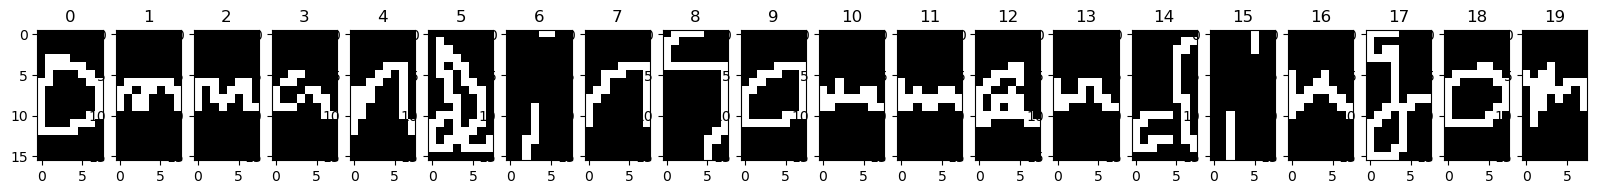

In [6]:
# Understand the profile of OCR raw data
print ("max of labels=", max(dataset1['labels']), " min of labels=", min(dataset1['labels']), 'num of labels=', len(dataset1['labelDic']))
print ("labelDic.keys()=", map(i2l, dataset1['labelDic'].keys()))
print ("Total number of lines=", len(dataset1['ids']))
print ("The shape of features:", np.array(dataset1['features']).shape)

print ("The first 10 ids:",dataset1['ids'][:10])
print ("ids[0]=",dataset1['ids'][0])
print ("labels[0]=", dataset1['labels'][0])
print ("The 1st letter is ", i2l(dataset1['labels'][0]))
print ("next_ids[0]=",dataset1['next_ids'][0])
# Show the matrix into an image
def showFeatures(features, num):
    plt.figure(figsize=(num, 6))
    
    for i in range(num):
        npfeature = np.array(features[i])
        plt.subplot(1,num,i+1)
        imshow(npfeature.reshape(16,8), cmap='gray')
        plt.title(i)

showFeatures(dataset1['features'],20)

# f1 = np.array(dataset1['features'])
# f1 = np.hstack([np.ones((f1.shape[0],1)), f1])
# print f1.shape
# dataset1['features'] = f1.tolist()
# d +=1

In [7]:
## groups data by word

from collections import defaultdict

def group_by_word(dataset):
    words = defaultdict(list)
    for i in range(len(dataset['labels'])):
        word_id = dataset['word_ids'][i]
        pos = dataset['positions'][i]
        feat = list(map(float, dataset['features'][i]))  # ensure float
        label = dataset['labels'][i]
        words[word_id].append((pos, feat, label))

    # Sort characters within each word by position
    X_seq, y_seq = [], []
    for word in words.values():
        word = sorted(word, key=lambda x: x[0])
        feats = [x[1] for x in word]
        labels = [x[2] for x in word]
        X_seq.append(feats)
        y_seq.append(labels)

    return X_seq, y_seq


In [8]:
def extract_sliding_window_features(sequence, window_size):
    pad = window_size // 2
    padded_seq = [np.zeros_like(sequence[0])]*pad + list(sequence) + [np.zeros_like(sequence[0])]*pad
    windowed_features = []
    for i in range(pad, len(padded_seq) - pad):
        window = padded_seq[i - pad: i + pad + 1]
        flat_window = np.concatenate(window)  # flatten the window into a single feature vector
        feature_dict = {f'f{j}': val for j, val in enumerate(flat_window)}
        windowed_features.append(feature_dict)
    return windowed_features


In [9]:
def decode_labels(y_seq):
    return [[chr(ord('a') + label) for label in word] for word in y_seq]


**Structural SVM**

In [10]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Group characters into words
X_seq, y_seq = group_by_word(dataset1)
# Limit dataset to 5000 samples
X_seq, y_seq = X_seq[:5000], y_seq[:5000]

# Flatten sequences using sliding window into a flat classification dataset
def build_dataset_from_sequences(X_seq, y_seq, window_size):
    X_flat, y_flat = [], []
    for x_seq, y_labels in zip(X_seq, y_seq):
        print(len(x_seq), y_labels)
        window_feats = extract_sliding_window_features(x_seq, window_size)
        X_flat.extend([list(f.values()) for f in window_feats])  # convert dict to list
        y_flat.extend(y_labels)
    return np.array(X_flat), np.array(y_flat)


# Build data
X_flat, y_flat = build_dataset_from_sequences(X_seq, y_seq, window_size= L)

X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, train_size=3000, random_state=42)

# Train SVM
clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Structured-like SVM (sliding window) accuracy:", acc)


9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13, 3, 8, 13, 6]
9 [14, 12, 12, 0, 13

In [11]:
def compute_word_level_accuracy(y_true_seq, y_pred_seq):
    correct_words = 0
    total_words = len(y_true_seq)

    for true_word, pred_word in zip(y_true_seq, y_pred_seq):
        if true_word == pred_word:
            correct_words += 1

    word_accuracy = correct_words / total_words
    return word_accuracy


In [12]:
from sklearn.svm import LinearSVC

# X_seq, y_seq from group_by_word
# Extract windowed features per word
X_win_seq = [extract_sliding_window_features(seq, window_size= L) for seq in X_seq]

# Flatten features and labels for training
X_all = [feat for seq in X_win_seq for feat in seq]
y_all = [label for seq in y_seq for label in seq]

# Vectorize features
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X_vec = vec.fit_transform(X_all)

# Train-test split (flattened)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_all, train_size=3000, random_state=42)
print(y_train)

# Train SVM
clf = LinearSVC()
clf.fit(X_train, y_train)

# Predict word-by-word
y_pred_seq = []
start = 0
for seq in X_win_seq:
    X_word = vec.transform(seq)
    pred_word = clf.predict(X_word)
    y_pred_seq.append(pred_word.tolist())

# Compute word-level accuracy
word_acc = compute_word_level_accuracy(y_seq, y_pred_seq)
print("Word-level accuracy:", word_acc)


[17, 11, 8, 4, 17, 13, 4, 13, 4, 8, 0, 24, 14, 13, 7, 20, 14, 4, 6, 0, 6, 10, 6, 11, 6, 12, 8, 24, 25, 10, 14, 6, 19, 18, 4, 8, 11, 20, 9, 13, 19, 25, 15, 2, 0, 19, 24, 21, 14, 15, 14, 13, 2, 8, 23, 10, 18, 18, 19, 8, 15, 13, 13, 20, 4, 12, 6, 8, 8, 14, 23, 18, 14, 6, 14, 13, 24, 2, 12, 14, 2, 24, 8, 13, 3, 13, 8, 7, 23, 14, 6, 17, 15, 21, 6, 21, 15, 0, 15, 12, 13, 13, 3, 0, 2, 8, 13, 11, 4, 19, 20, 8, 20, 6, 14, 18, 24, 4, 11, 5, 14, 4, 6, 13, 5, 4, 8, 18, 11, 25, 17, 14, 14, 20, 16, 6, 0, 12, 11, 14, 14, 17, 8, 13, 15, 14, 11, 14, 15, 4, 11, 4, 2, 4, 10, 4, 13, 1, 13, 8, 20, 16, 1, 8, 7, 15, 8, 20, 13, 5, 11, 13, 15, 24, 1, 20, 6, 4, 11, 15, 0, 12, 11, 4, 6, 2, 25, 24, 3, 12, 20, 14, 11, 11, 8, 6, 14, 11, 8, 0, 14, 8, 2, 19, 19, 20, 6, 13, 9, 7, 13, 7, 14, 0, 0, 4, 21, 24, 22, 13, 14, 9, 12, 4, 25, 17, 17, 14, 4, 0, 4, 8, 11, 14, 6, 17, 4, 4, 11, 4, 8, 3, 8, 18, 0, 19, 23, 4, 11, 4, 15, 4, 13, 19, 11, 5, 2, 17, 1, 0, 1, 2, 13, 13, 7, 11, 19, 18, 13, 9, 14, 24, 5, 13, 21, 6, 20, 17, 0

In [13]:
y_pred_seq

[[14, 12, 12, 0, 13, 10, 8, 13, 6],
 [14, 20, 11, 0, 13, 3, 8, 13, 6],
 [14, 25, 12, 0, 13, 3, 8, 13, 6],
 [14, 12, 12, 0, 17, 3, 8, 13, 6],
 [14, 21, 13, 0, 13, 12, 8, 13, 6],
 [14, 12, 13, 0, 13, 3, 8, 13, 6],
 [6, 12, 12, 8, 13, 3, 8, 13, 6],
 [14, 12, 12, 16, 13, 10, 8, 13, 6],
 [14, 12, 12, 0, 13, 3, 8, 13, 6],
 [14, 12, 4, 0, 13, 8, 8, 13, 6],
 [14, 13, 13, 0, 21, 3, 8, 13, 6],
 [14, 12, 13, 17, 3, 3, 8, 13, 6],
 [14, 20, 12, 0, 13, 10, 8, 13, 6],
 [14, 12, 12, 8, 13, 3, 11, 13, 6],
 [14, 12, 12, 0, 13, 3, 8, 13, 6],
 [14, 12, 12, 0, 13, 3, 8, 13, 6],
 [14, 12, 12, 8, 13, 3, 8, 13, 6],
 [14, 12, 12, 0, 13, 7, 8, 13, 6],
 [14, 12, 4, 0, 13, 13, 8, 13, 6],
 [14, 12, 12, 4, 13, 0, 8, 13, 6],
 [14, 14, 12, 0, 13, 3, 8, 13, 6],
 [14, 12, 12, 0, 13, 3, 11, 13, 6],
 [14, 12, 12, 4, 13, 1, 8, 4, 6],
 [14, 12, 12, 0, 13, 3, 8, 13, 6],
 [14, 12, 12, 0, 13, 6, 8, 13, 6],
 [14, 12, 12, 0, 13, 3, 8, 13, 6],
 [14, 12, 3, 0, 14, 15, 11, 15, 6],
 [14, 21, 12, 4, 13, 6, 8, 7, 6],
 [14, 12, 12, 0,

**Maximum Margin Markov Networks**

In [14]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

n_labels = 26  # 'a' to 'z'

def extract_sliding_window_features(sequence, window_size):
    pad = window_size // 2
    padded_seq = [np.zeros_like(sequence[0])] * pad + list(sequence) + [np.zeros_like(sequence[0])] * pad
    windowed_features = []
    for i in range(pad, len(padded_seq) - pad):
        window = padded_seq[i - pad: i + pad + 1]
        flat_window = np.concatenate(window)  # flatten the window into a single feature vector
        feature_dict = {f'f{j}': val for j, val in enumerate(flat_window)}
        windowed_features.append(feature_dict)
    return windowed_features

# Transition weights training as before
def train_transition_weights(y_seq_encoded):
    transition_counts = np.zeros((n_labels, n_labels))
    for seq in y_seq_encoded:
        for i in range(len(seq) - 1):
            transition_counts[seq[i], seq[i + 1]] += 1
    transition_weights = transition_counts / (transition_counts.sum(axis=1, keepdims=True) + 1e-5)
    return np.log(transition_weights + 1e-5)

# Viterbi decoding as before
def viterbi_decode(emission_scores, transition_weights):
    T = len(emission_scores)
    scores = np.zeros((T, n_labels))
    backpointers = np.zeros((T, n_labels), dtype=int)

    scores[0] = emission_scores[0]
    for t in range(1, T):
        for curr in range(n_labels):
            prev_scores = scores[t - 1] + transition_weights[:, curr]
            best_prev = np.argmax(prev_scores)
            scores[t, curr] = emission_scores[t][curr] + prev_scores[best_prev]
            backpointers[t, curr] = best_prev

    best_last = np.argmax(scores[T - 1])
    best_path = [best_last]
    for t in range(T - 1, 0, -1):
        best_path.append(backpointers[t, best_path[-1]])
    return best_path[::-1]

# Train emission classifier using dict features
def train_emission_classifier_with_dict_features(X_seq, y_seq, window_size):
    X_flat_dicts = []
    y_flat = []
    for seq, labels in zip(X_seq, y_seq):
        features = extract_sliding_window_features(seq, window_size)
        X_flat_dicts.extend(features)
        y_flat.extend(labels)
    vec = DictVectorizer(sparse=False)
    X_flat = vec.fit_transform(X_flat_dicts)
    clf = SGDClassifier(loss='hinge', max_iter=1000)
    clf.fit(X_flat, y_flat)
    return clf, vec

# Predict using sliding window + viterbi
def predict_m3n_with_dict_features(X_seq, clf, vec, trans_weights, window_size):
    predictions = []
    for seq in X_seq:
        features = extract_sliding_window_features(seq, window_size)
        X_window = vec.transform(features)
        emission_scores = clf.decision_function(X_window)
        pred_seq = viterbi_decode(emission_scores, trans_weights)
        predictions.append(pred_seq)
    return predictions

# Accuracy metrics
def char_level_accuracy(y_true_seq, y_pred_seq):
    total = sum(len(seq) for seq in y_true_seq)
    correct = sum(t == p for y_t, y_p in zip(y_true_seq, y_pred_seq) for t, p in zip(y_t, y_p))
    return correct / total

def word_level_accuracy(y_true_seq, y_pred_seq):
    correct = sum(np.array_equal(t, p) for t, p in zip(y_true_seq, y_pred_seq))
    return correct / len(y_true_seq)

# ===== Example pipeline =====
def train_m3n_pipeline_with_sliding_window(X_seq, y_seq, window_size, train_size=3000):
    # Flatten all labels to fit LabelEncoder
    all_labels = [label for seq in y_seq for label in seq]
    le = LabelEncoder()
    le.fit(all_labels)
    y_seq_encoded = [le.transform(seq) for seq in y_seq]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq_encoded, train_size=train_size, random_state=42)

    # Train transition weights
    trans_weights = train_transition_weights(y_train)

    # Train emission classifier with sliding windows
    clf, vec = train_emission_classifier_with_dict_features(X_train, y_train, window_size)

    # Predict on test set
    y_pred = predict_m3n_with_dict_features(X_test, clf, vec, trans_weights, window_size)

    # Evaluate (using encoded labels)
    w_acc = word_level_accuracy(y_test, y_pred)
    c_acc = char_level_accuracy(y_test, y_pred)

    print(f"Word-level Accuracy: {w_acc:.4f}")
    print(f"Character-level Accuracy: {c_acc:.4f}")

    # Optional: decode labels back to original chars
    y_test_decoded = [le.inverse_transform(seq) for seq in y_test]
    y_pred_decoded = [le.inverse_transform(seq) for seq in y_pred]

    return clf, vec, trans_weights, le, (X_test, y_test_decoded, y_pred_decoded)

# === Usage example ===
clf, vec, trans_weights, le, results = train_m3n_pipeline_with_sliding_window(X_seq, y_seq, window_size=L)
X_test, y_test_decoded, y_pred_decoded = results


Word-level Accuracy: 0.5545
Character-level Accuracy: 0.8638


**Conditional Random Fields**

In [15]:
from sklearn.model_selection import train_test_split

def prepare_crf_data(dataset, window_size):
    X_seq, y_seq = group_by_word(dataset)
    X_train, X_test, y_train, y_test = train_test_split(X_seq[:5000], y_seq[:5000], train_size=3000, random_state=42)

    X_train_feats = [extract_sliding_window_features(seq, window_size) for seq in X_train]
    X_test_feats = [extract_sliding_window_features(seq, window_size) for seq in X_test]

    return X_train_feats, X_test_feats, y_train, y_test


In [16]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

def train_crf(X_train, y_train, X_test, y_test):
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )

    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)

    flat_true = [label for seq in y_test for label in seq]
    flat_pred = [label for seq in y_pred for label in seq]
    acc_char = np.mean(np.array(flat_true) == np.array(flat_pred))
    acc_word = np.mean([yt == yp for yt, yp in zip(y_test, y_pred)])

    print("Character-Level Accuracy:", acc_char)
    print("Word-Level Accuracy:", acc_word)


In [17]:
X_train, X_test, y_train, y_test = prepare_crf_data(dataset1, window_size= L)
y_train_str = decode_labels(y_train)
y_test_str = decode_labels(y_test)
train_crf(X_train, y_train_str, X_test, y_test_str)


Character-Level Accuracy: 0.889564479638009
Word-Level Accuracy: 0.673
